In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import IPython
import seaborn as sns
import arviz as az
import csv
import json
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
# from google.colab import files

print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.8
Running on ArviZ v0.6.1


In [2]:
if False:
    # import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    # import numpy as np
    from matplotlib.mlab import bivariate_normal


    N = 100
    X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]

    # A low hump with a spike coming out of the top right.
    # Needs to have z/colour axis on a log scale so we see both hump and spike.
    # linear scale only shows the spike.
    Z1 = bivariate_normal(X, Y, 0.1, 0.2, 1.0, 1.0) + 0.1 * bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)

    plt.subplot(2, 1, 1)
    plt.pcolor(X, Y, Z1, norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()), cmap='PuBu_r')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.pcolor(X, Y, Z1, cmap='PuBu_r')
    plt.colorbar()


    plt.show()

In [3]:
#@ def, Plot heatmaps subplots 
def plotHeatmaps(data,
                 rowTitles,
                 colTitles,
                 xLabel,
                 yLabel,
                 nRows,
                 nCols,
                 vmins,
                 vmaxs,
                 iRow):

    ticklablesFontsize = 14
    cbarFontSize = 14
        
    fig = plt.figure(figsize=[4,12])
    
    # im identifier:
    im = [None]*nCols
    x1, x2 = data[0] # Free parameters of the data.
    f = data[1] # Data that is the function of the free parameters.
    
    # Return the last row that is 'True' in 'plotWhat'. It sets in what row 
    # to show 'xlabel':
    max_plotWhat = np.max(np.where(plotWhat))
    
    # plot the nRows x nCols subplots with labels, titles at  
    # sceciefic locations. iCol is Column index, iRow is Row index:
    for iCol in range(nCols):        
        ax = fig.add_subplot(nRows, nCols, iRow*nCols + iCol+1)
        im[iCol] = plt.pcolor(10**x1 ,10**x2, 10**f[iCol],
                              shading='auto', cmap='Blues',
                              norm=colors.LogNorm())
        
        if True:  #iRow > 0:
            DL_levels = np.arange(0., 3., 0.25)
            cs = plt.contour(10**x1 ,10**x2, 10**f[iCol],
                        10**DL_levels, colors='k',
                        vmin=vmins[iCol], vmax=vmaxs[iCol])
            plt.clabel(cs, 10**DL_levels, inline=True, fmt='%.0f', fontsize=10)
        
        cbar0 = fig.colorbar(im[iCol])
        cbar0.ax.set_title('nm', fontsize=cbarFontSize)
        
        ax.set_xlim(10**-5.2, 10**-0.4)
        ax.set_xticklabels(x1, fontsize=ticklablesFontsize)
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=6))
        
        ax.set_ylim(10**-3.1, 10**-0.7)
        ax.set_yticklabels(x2, fontsize=ticklablesFontsize)
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=7))
        
        
        ##################################################
        
        if iRow == 0:
            plt.title(colTitles[iCol] + rowTitles[iRow])
        
        else:
            plt.title(rowTitles[iRow])
        
        if iRow == max_plotWhat:
            plt.xlabel(xLabel)
            
        if iCol == 0:
            plt.ylabel(yLabel)
    
    fig.tight_layout()
    

In [4]:
DataToPlot = 4*[None]
plotWhat = [True,False,False,False]

def plotData(DataToPlot,plotWhat):
    # titles and labels:
#     xLabel = "$log_{10}(Poff_{LCK*}^{LCKA}$)"
#     yLabel = "$log_{10}(D_{LCK*}^{LCKA}) (\mu m^2/sec)$"
#     DLALck_Title = "$logDecaylength_{Lck*}^{LCKA}[nm]$\n" # Decaylength
    xLabel = "$Poff_{LCK*}^{LCKA}$"
    yLabel = "$D_{LCK*}^{LCKA} [\mu m^2/sec]$"
    DLALck_Title = "$Decaylength_{Lck*}^{LckA}[nm]$\n" # Decaylength
    colTitles = [DLALck_Title]
    
    
    rowTitles = ["Training data","Fit data","Trained parameters","Surrogate"]

    # min and max values for the different heatmaps:
    vmins = [0]
    vmaxs = [3.0]

    nRows = 4
    nCols = 1
    
    # Plot a row of subplot if the data is not empty and if value is 'True':
    for iRow in range(nRows):
        if DataToPlot[iRow] != None and plotWhat[iRow]:
            plotHeatmaps(data = DataToPlot[iRow],
                         nRows = nRows,
                         nCols = nCols,
                         rowTitles = rowTitles,
                         colTitles = colTitles,
                         xLabel = xLabel,
                         yLabel = yLabel,
                         vmins = vmins,
                         vmaxs = vmaxs,
                         iRow = iRow)


In [5]:
#@title Training data for model2 { vertical-output: true, display-mode: "form" }
# lambdaALCK_array0: x-axis is Poff (probability of spontaneous decay); 
# y-axis is Diff (diffusion coefficient in micron^2/sec); 
# z-axis is exponontial factor 'lambda': 'y = exp(-lambda*x)' in 1/nm.
lambdaALCK_array0 = -1*np.array([[-0.014657,-0.014447,-0.014664,-0.015526,-0.01714,-0.022992,-0.034524,-0.070557,-0.11387,-0.20832,-0.01],
[-0.012456,-0.012384,-0.013487,-0.013015,-0.01379,-0.018903,-0.03389,-0.052318,-0.093198,-0.15276,-0.01],
[-0.0098342,-0.0096907,-0.0098001,-0.010041,-0.011918,-0.017406,-0.026369,-0.039222,-0.057673,-0.11743,-0.01],
[-0.0080017,-0.0077559,-0.0076087,-0.0082535,-0.0099144,-0.012286,-0.01889,-0.03604,-0.054248,-0.095491,-0.01],
[-0.0058524,-0.0056572,-0.0072154,-0.0066482,-0.0078467,-0.010037,-0.014898,-0.028174,-0.04584,-0.071974,-0.01],
[-0.0046865,-0.0047947,-0.0044626,-0.0045893,-0.0049986,-0.0081368,-0.014763,-0.019339,-0.035599,-0.060622,-0.01],
[-0.0036558,-0.0031606,-0.0036487,-0.0046674,-0.0031157,-0.0048789,-0.011206,-0.019952,-0.028773,-0.07807,-0.01],
[-0.0024369,-0.0024442,-0.0025014,-0.0024395,-0.0035739,-0.0049891,-0.0062023,-0.010665,-0.018304,-0.029732,-0.01],
[-0.0016189,-0.0017432,-0.0013415,-0.0026006,-0.0021152,-0.0028547,-0.0089079,-0.0074472,-0.017615,-0.024174,-0.01],
[-0.0013258,-0.00074239,-0.00067486,-0.0013035,-0.0019591,-0.0021911,-0.0065414,-0.0074576,-0.016519,-0.65039,-0.01],
[-0.00060974,-0.00027457,-0.00018559,-0.00016811,-0.00085357,-0.0020511,-0.0026312,-0.0053513,-0.038536,-0.014071,-0.01],
[-0.00052181,-0.00050238,-0.00016453,-0.00011248,-0.00068145,-0.00015995,-0.0014959,-0.0041252,-0.0048673,-0.0055963,-0.01],
[-7.0125e-05,-0.00049168,-0.00062104,-0.00094581,-6.2083e-05,-0.0002202,-0.00032468,-0.0053617,-0.01093,-0.01741,-0.01]])

# cropping the last column:
# lambdaALCK_array = lambdaALCK_array0[:,:-1]
lambdaALCK_array = lambdaALCK_array0[:-3,:-1]
DLALCK_array = 1./lambdaALCK_array
logDLALCK_array = np.log10(DLALCK_array)

logDiff0 = np.arange(-3, 0.25, 0.25) 
logPoff0 = np.arange(-5, 0.0, 0.5) 

logDiff = logDiff0[:-3]
logPoff = logPoff0[:]

print(['logDiff.shape =',logDiff.shape])
print(['logPoff.shape =',logPoff.shape])

logPoff_array, logDiff_array  = np.meshgrid(logPoff, logDiff)

if True:
    np.save("logDLALCK_array.csv", logDLALCK_array)
    

['logDiff.shape =', (10,)]
['logPoff.shape =', (10,)]


In [6]:
#@title Convert trainingData to dataFrames
df_trainingData_model2 = pd.DataFrame(np.array([logPoff_array.flatten(), 
                   logDiff_array.flatten(),  
                   logDLALCK_array.flatten()]).T, # 
                   columns=['logPoff','logDiff','logDLALCK'])

df_trainingData_model2.to_csv('trainingData_model2.csv')

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


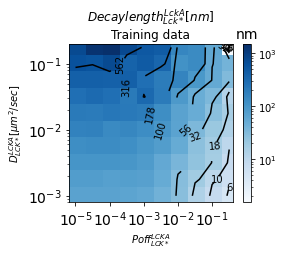

In [7]:

df_logDLALCK = df_trainingData_model2.pivot('logDiff', 'logPoff', 'logDLALCK')

df_logPoff = df_logDLALCK.columns
df_logDiff = df_logDLALCK.index

logDLALCK = df_logDLALCK.values

DataToPlot[0] = [[df_logPoff,df_logDiff],[logDLALCK]]
plotWhat=[True,False,False,False]

plotData(DataToPlot, plotWhat)


In [8]:
#@title 2.2.1 Defined fit fnctions
# fl is for 'flatten'
fitEquation = "b + ax*x + ay*y"
def linear_z(xy, b, ax, ay):
    x,y = xy
    f = b + ax*x + ay*y
    
    return f

# def linear_z(xy, b, ax, ay, fitEquation):
#     x,y = xy
#     f = eval(fitEquation)
    
#     return f

In [9]:
def fitEquationStr(x,y,b,ax,ay):
    
    return b + "+" + ax + "*" + "x" + "+" + ay + "*" + y

fitEquationStr("x","y","intercept","xSlope","ySlope")
    

'intercept+xSlope*x+ySlope*y'

In [10]:
#@title Read training data from csv file
# Reading data from csv file:
df_trainingData_model2 = pd.read_csv('trainingData_model2.csv')

# Reading data from DataFrame:
# 'f' is for 'flatten'  
flogPoff = df_trainingData_model2['logPoff']
flogDiff = df_trainingData_model2['logDiff']
flogDLALCK = df_trainingData_model2['logDLALCK']


In [11]:
#@title 2.2.2. Get fit parameters
def get_fit_parameters(X,fitFunc,fXdata,parametersNames,p0):
    """
    Returns fit parameters and aranges them in DataFrames where the index (rows)
    are the fit parameters' names and the columns are 'mu' and 'sd'.
    """
    popt, pcov = curve_fit(fitFunc, X, fXdata, p0)
    mu = popt
    sd = np.sqrt(np.diag(pcov))

    data = {'mu':mu,'sd':sd}
    index = parametersNames
    
    df = pd.DataFrame(data,index=index)

    return df

In [12]:
#@title Fit parameters for logDLALCK

p0_DLALCK = 0., 0., 0.
parametersNames_logDLALCK = ['intercept', 'PoffSlope', 'DiffSlope']

df_fitParameters_logDLALCK = get_fit_parameters(X = (flogPoff,flogDiff),
                              fitFunc = linear_z,
                              fXdata = flogDLALCK,
                              parametersNames = parametersNames_logDLALCK,
                              p0 = p0_DLALCK)

df_fitParameters_logDLALCK = df_fitParameters_logDLALCK.round(3)
display(df_fitParameters_logDLALCK)

,mu,sd
intercept,1.972,0.080
PoffSlope,-0.280,0.016
DiffSlope,0.422,0.033


In [13]:
#@title 2.2.3. Plotting training data vs. data fit
# decayLengthALCK:
logDLALCK_fit = df_fitParameters_logDLALCK.loc['intercept','mu'] + \
                df_fitParameters_logDLALCK.loc['PoffSlope','mu']*logPoff_array + \
                df_fitParameters_logDLALCK.loc['DiffSlope','mu']*logDiff_array

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


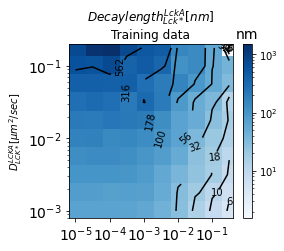

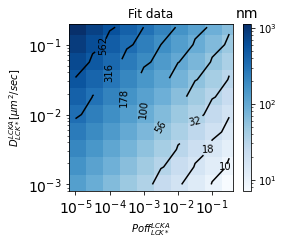

In [14]:
DataToPlot[1] = [[logPoff,logDiff],[logDLALCK_fit]]
plotWhat=[True,True,False,False]

plotData(DataToPlot, plotWhat)

# 2.3. Data structure

In [15]:
#@title Class RV new
class RV: # TODO for Barak - make CSV field names correspond to dictionary names or have a meta-dict for it
    def __init__(self,
                 id : str,
                 type2 : str,
                 shortName : str,
                 texName : str,
                 description : str,
                 distribution : str,
                 distributionParameters : dict,
                 units : str):
        
        self.id = id # str
        self.type2 = type2 # str
        self.shortName = shortName # str
        self.texName = texName # str
        self.description = description # str
        self.distribution = distribution # str
        self.distributionParameters = distributionParameters # array
        self.units = units # str


    def get_as_dictionary(self):  
        return {'ID': self.id, # Unique variable name that is used by pymc3, e.g. rv_tSlope_wTCR_KSEG1.
                'Type': self.type2, # Type of variable, e.g. 'Free parameter', 'Random variable'
                'Short Name': self.shortName, # Short name, e.g. 't'.
                'Latex Name': self.texName, # LaTex name for display.
                'Description': self.description, # 
                'Distribution': self.distribution,
                'Distribution parameters': self.distributionParameters,
                'Units': self.units}   

    def get_pymc3_statement():
        '''
        TASK 1
        TODO make this return a 2-tuple from a variable name 
        to a pymc3 statment for creating this random variable
        (to be used as input for eval)
        '''
#         if RV.distribution == "Normal":
#             mu = RV.distributionParameters["mu"]
#             sd = RV.distributionParameters["sd"]
#             s0 = RV.id
#             if RV.shortName == "output":
#                 print(RV.shortName)
#             s1 = ("pm." + RV.distribution + "('" + RV.id  + "'" + \
#                                       ", mu=" + str(mu) + \
#                                       ", sd=" + str(sd) + ")")
#             s = (s0,s1)
#             print(eval("s[0]"),"=",eval("s[1]"))
        '''
        Example: return tuple :
        s = ('rv_alpha', 'pm.Normal("rv_alpha", mu=354, sigma=a*10+b*20)')
        so we can do eval(s[0]) = eval(s[1])
        '''
      # TODO: WRITE-ME
#       return

    @staticmethod
    def RV_from_dictionary(d : dict):
          ''' generates an RV object from a dictionary produced by get_as_dictionary() '''  
          return RV(id=d['ID'],
                    type2=d['Type'],
                    shortName=d['Short Name'],
                    texName=d['Latex Name'],
                    description=d['Description'],
                    distribution=d['Distribution'],
                    distributionParameters=d['Distribution parameters'],
                    units=d['Units'])


In [16]:
#@title Class model

class Model:
    # Constructor
    def __init__(self, 
                 shortName : str, 
                 longName : str, 
                 description : str, 
                 model_id  : str,
                 RV_csv_file = None, # Topology of Bayes net
                 data_csv_file = None): # Training data
        '''
        '''
        self.shortName = shortName # str
        self.longName = longName # str
        self.description = description # str
        self.model_id = model_id # str
        self.set_RVs_from_csv(RV_csv_file) # fill in random variables from CSV file
        self.set_data_from_csv(data_csv_file) # fill in training data from CSV file

    # add a random variable to the model
    def add_rv(self, rv): # BARAK
        self.RVs.append(rv)

    def get_dataframe(self): # TODO: think about the name
        info = [ rv.get_as_dictionary() for rv in self.RVs ]
        df = pd.DataFrame(info)
        df.set_index('ID', drop=False)  
        return df

    def to_csv(self, csv_file): # TODO: think about the name
        df = self.get_dataframe()
        df.to_csv(csv_file)

    def set_RVs_from_csv(self, csv_file):
        ''' 
        read csv file (similar to Table S1 in metamodeling paper) with random variables
        and set this model's random variables and the statistical relations among them
        accordingly

        If csv_file is None, set an empty list of RVs
        '''
        self.RVs = []
        if csv_file == None:
            return
        df = pd.read_csv(csv_file)
        # TODO: assert that it has all the right fields
        rv_dicts = df.to_dict('records') # TODO: check if this is still appropraite
        print("RV dicts from csv:")
        print(rv_dicts)
        for rv_dict in rv_dicts:
            rv= RV.from_dictionary(rv_dict)
            self.add_rv(rv)

    def set_data_from_csv(self, data_csv_file):
    # TASK 2
        # df = pd.read_csv(data_csv_file)
        # display(df) # Yair
        # TODO: code for filling in table of data
        # self.data = ... # WRITE-ME
        self.trainingData = pd.read_csv(data_csv_file)

    # generate a pymc3 model from this model
    def get_as_pymc3(self): # BARAK
    # TASK 3 - make sure this works
        '''
        Go over all random variables in this model, 
        and generate a PyMC3 object with cooresponding
        variable names and statistical relations among them
        '''
        # TODO (use "eval" command)
        pm_model = pm.Model()
        with pm_model as pm:
             for rv in self.RVs:
                 pass
            #    s = rv.get_pymc3_statement()
            #    eval(s[0]) = eval(s[1])
        return pm_model

    def update_rvs_from_pymc3(self, pymc3): # BARAK
    # TASK 4 
        # TODO: use trace from trained PyMC3 model to update statements for all RVs
        return

    
     

In [17]:
#@title Start model2_decayLengthALCK
model2_description = """Steady state of the spatial distribution of active Lck,
(Lck*), molecules relative to a fixed CD45 location. The distribution of the Lck*
molecules is determined by their diffusion coefficient and their spontanous decay
probability."""

model2_logDLALCK = Model(shortName = 'LCKA',  # str
               longName = 'Lck activation', # str
               description = 'Model2 description', # str
               model_id = '2', #, # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model2.csv') 


In [18]:
#@title Define lambdaALCK untrained table

# decayLengthALCK
model2_logDLALCK.add_rv(
    RV(id = 'fp_logPoff_logDLALCK_ALCK2',
       type2 = 'Free parameter',
       shortName = 'logPoff',
       texName = "$$logPoff^{ALCK}$$",
       description = 'log10 of deactivation probability',
       distribution = 'Normal',
       distributionParameters = {'mu' :str(-4.), 'sd' : str(1.)},
       units = '$$-$$'))

model2_logDLALCK.add_rv(
    RV(id = 'fp_logDiff_logDLALCK_ALCK2',
        type2 = 'Free parameter',
        shortName = 'logDiff',
        texName = '$$logDiff^{ALCK}$$',
        description = 'log10 of diffuion coefficient',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(-2.), 'sd' : str(1.)},
        units = '$$\mu m^2/sec$$'))

model2_logDLALCK.add_rv(
    RV(id = 'rv_intercept_logDLALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'intercept',
        texName = '$$decayLength^{ALCK}_{intercepct}$$',
        description = 'Intercept of plain with origin',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_logDLALCK.loc['intercept','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_logDLALCK.loc['intercept','sd'])},
        units = '$$nm^{-1}$$')) 

model2_logDLALCK.add_rv(
    RV(id = 'rv_PoffSlope_logDLALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'PoffSlope',
        texName = '$$decayLength^{ALCK}_{PoffSlope}$$',
        description = 'Plain slope for logPoff',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_logDLALCK.loc['PoffSlope','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_logDLALCK.loc['PoffSlope','sd'])},
        units = '$$-$$')) 

model2_logDLALCK.add_rv(
    RV(id = 'rv_DiffSlope_logDLALCK_ALCK2',
        type2 = 'Random variable',
        shortName = 'DiffSlope',
        texName = '$$decayLength^{ALCK}_{DiffSlope}$$',
        description = 'Plain slope for logDiff',
        distribution = 'Normal',
        distributionParameters = {'mu' : str(df_fitParameters_logDLALCK.loc['DiffSlope','mu']), # TODO: get from table 
                                  'sd' : str(df_fitParameters_logDLALCK.loc['DiffSlope','sd'])},
        units = '$$-$$')) 

model2_logDLALCK.add_rv(
    RV(id = 'rv_output_logDLALCK_ALCK2',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$decayLength^{ALCK}_{output}$$',
       description = 'Decay length output',
       distribution = 'Normal',
       distributionParameters = {'mu' : str(2.), 'sd' : str(0.5)},
       units = "$$nm$$")) 

model2_logDLALCK.to_csv("model2_logDLALCK.csv")

In [19]:
# Display model2_DLALCK untrained table:
df_model2_logDLALCK_untrainedTable = model2_logDLALCK.get_dataframe()
df_model2_logDLALCK_untrainedTable = df_model2_logDLALCK_untrainedTable.set_index('ID')

display(df_model2_logDLALCK_untrainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(0, 100, 255, 0.20)',
                                                'border' : '1px black solid'}))

# Math(r"e^\alpha")

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_logDLALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,log10 of deactivation probability,Normal,"{'mu': '-4.0', 'sd': '1.0'}",$$-$$
fp_logDiff_logDLALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,log10 of diffuion coefficient,Normal,"{'mu': '-2.0', 'sd': '1.0'}",$$\mu m^2/sec$$
rv_intercept_logDLALCK_ALCK2,Random variable,intercept,$$decayLength^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': '1.972', 'sd': '0.08'}",$$nm^{-1}$$
rv_PoffSlope_logDLALCK_ALCK2,Random variable,PoffSlope,$$decayLength^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': '-0.28', 'sd': '0.016'}",$$-$$
rv_DiffSlope_logDLALCK_ALCK2,Random variable,DiffSlope,$$decayLength^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': '0.422', 'sd': '0.033'}",$$-$$
rv_output_logDLALCK_ALCK2,Random variable,output,$$decayLength^{ALCK}_{output}$$,Decay length output,Normal,"{'mu': '2.0', 'sd': '0.5'}",$$nm$$


In [20]:
# concatanate untrained tables:

df_model2_untrainedTable = pd.concat([df_model2_logDLALCK_untrainedTable],
                                      ignore_index=False)

# select "Free parameter" rows:
# fpRows = df_model2_untrainedTable.loc[:,'Type'] == "Free parameter"

# select "Random variable" rows:
# rv1Rows = df_model2_untrainedTable.loc[:,'Type'] == "Random variable"

display(df_model2_untrainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(0, 100, 255, 0.20)',
                                                'border' : '1px black solid'}))



,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_logDLALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,log10 of deactivation probability,Normal,"{'mu': '-4.0', 'sd': '1.0'}",$$-$$
fp_logDiff_logDLALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,log10 of diffuion coefficient,Normal,"{'mu': '-2.0', 'sd': '1.0'}",$$\mu m^2/sec$$
rv_intercept_logDLALCK_ALCK2,Random variable,intercept,$$decayLength^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': '1.972', 'sd': '0.08'}",$$nm^{-1}$$
rv_PoffSlope_logDLALCK_ALCK2,Random variable,PoffSlope,$$decayLength^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': '-0.28', 'sd': '0.016'}",$$-$$
rv_DiffSlope_logDLALCK_ALCK2,Random variable,DiffSlope,$$decayLength^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': '0.422', 'sd': '0.033'}",$$-$$
rv_output_logDLALCK_ALCK2,Random variable,output,$$decayLength^{ALCK}_{output}$$,Decay length output,Normal,"{'mu': '2.0', 'sd': '0.5'}",$$nm$$


# Untrained model

In [21]:
#@title Untrained model

def get_pm_model2_untrained(df_trainingData_model2):
    
    pm_model2 = pm.Model()
    with pm_model2:
        dfRV = df_model2_untrainedTable
        DP = 'Distribution parameters'
        
        # model2.D:
        logPoff_LCKA2_obs = df_trainingData_model2.loc[:,'logPoff'].values
        logDiff_LCKA2_obs = df_trainingData_model2.loc[:,'logDiff'].values

        logDLALCK_ALCK2_obs = df_trainingData_model2.loc[:,'logDLALCK'].values
        
        # rv_logPoff
        ID = 'fp_logPoff_logDLALCK_ALCK2'
        rv_logPoff = pm.Normal('rv_logPoff',
            mu = eval(dfRV.loc[ID,DP]['mu']),
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = logPoff_LCKA2_obs)
        
        # rv_logDiff
        ID = 'fp_logDiff_logDLALCK_ALCK2'
        rv_logDiff = pm.Normal('rv_logDiff',
            mu = eval(dfRV.loc[ID,DP]['mu']),
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = logDiff_LCKA2_obs) # todo values
        
        
        # decayLengthALCK ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_logDLALCK_ALCK2
        ID = 'rv_intercept_logDLALCK_ALCK2'
        rv_intercept_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_PoffSlope_logDLALCK_ALCK2
        ID = 'rv_PoffSlope_logDLALCK_ALCK2'
        rv_PoffSlope_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_DiffSlope_logDLALCK_ALCK2
        ID = 'rv_DiffSlope_logDLALCK_ALCK2'
        rv_DiffSlope_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_output_logDLALCK_ALCK2, equation:
        ID = 'rv_output_logDLALCK_ALCK2'
        rv_output_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = rv_intercept_logDLALCK_ALCK2 +\
            rv_PoffSlope_logDLALCK_ALCK2*rv_logPoff +\
            rv_DiffSlope_logDLALCK_ALCK2*rv_logDiff,
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = logDLALCK_ALCK2_obs) #
        
        #############################################################
    return pm_model2



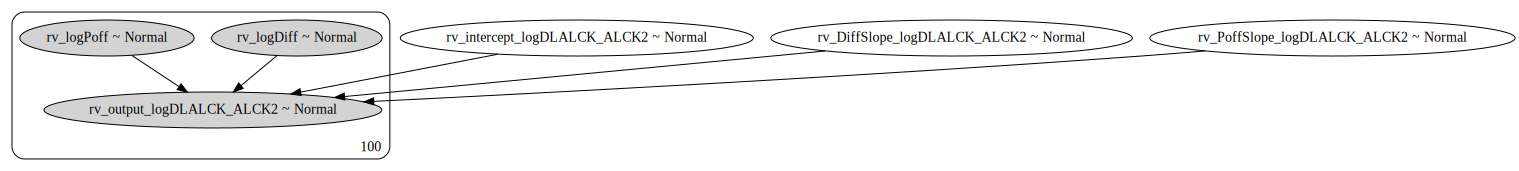

In [22]:
pm_model2= get_pm_model2_untrained(df_trainingData_model2) 
gv2 = pm.model_to_graphviz(pm_model2)
gv2

In [23]:
if False:
    gv2.render("model2_graph", format="png")
    files.download("model2_graph.png") # Download locally from colab

In [24]:
with pm_model2:
    trace2 = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:13<00:00, 758.97draws/s]
The acceptance probability does not match the target. It is 0.882969013495793, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


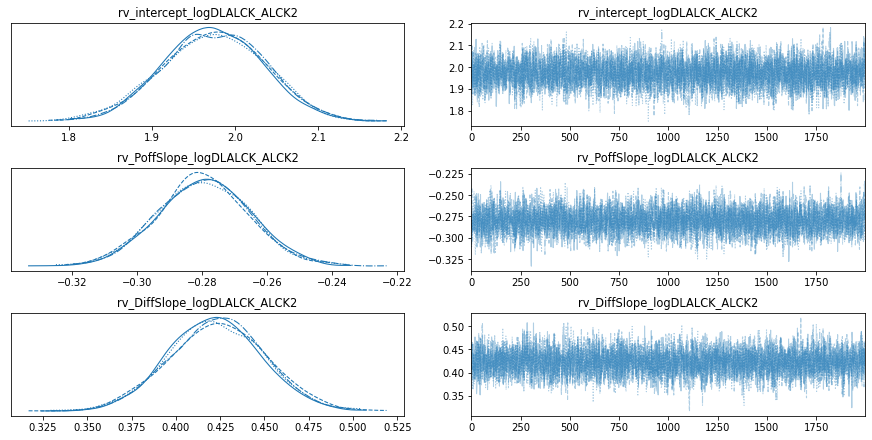

In [25]:
pm.traceplot(trace2);

In [26]:
# save trace_summary:
trace2_summary = pm.summary(trace2).round(3) # var_names=["mu", "tau"]
trace2_summary.to_pickle('trace2_summary')


C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [27]:
#@title Read 'mean' and 'sd' values from 'trace_summary'
# r = read, to distinguish between the original and the saved files.
trace2_summary_r = pd.read_pickle('trace2_summary') 

# displaying the rv names and the data of intersest: 'mean' and 'sd':
mean_sd_r = trace2_summary_r.loc[:, ['mean','sd']]
mean_sd_r

,mean,sd
rv_intercept_logDLALCK_ALCK2,1.973,0.060
rv_PoffSlope_logDLALCK_ALCK2,-0.280,0.014
rv_DiffSlope_logDLALCK_ALCK2,0.423,0.026


In [28]:
#@ Update trained parameters values
df_model2_trainedTable = df_model2_untrainedTable
DP = 'Distribution parameters'
for rv in mean_sd_r.index:
#     print(rv)
    df_model2_trainedTable.loc[rv,DP]['mu'] = str(mean_sd_r.loc[rv]['mean'])
    df_model2_trainedTable.loc[rv,DP]['sd'] = str(mean_sd_r.loc[rv]['sd'])

df_model2_trainedTable.to_pickle('df_model2_trainedTable')
df_model2_trainedTable

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_logDLALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,log10 of deactivation probability,Normal,"{'mu': '-4.0', 'sd': '1.0'}",$$-$$
fp_logDiff_logDLALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,log10 of diffuion coefficient,Normal,"{'mu': '-2.0', 'sd': '1.0'}",$$\mu m^2/sec$$
rv_intercept_logDLALCK_ALCK2,Random variable,intercept,$$decayLength^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': '1.973', 'sd': '0.06'}",$$nm^{-1}$$
rv_PoffSlope_logDLALCK_ALCK2,Random variable,PoffSlope,$$decayLength^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': '-0.28', 'sd': '0.014'}",$$-$$
rv_DiffSlope_logDLALCK_ALCK2,Random variable,DiffSlope,$$decayLength^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': '0.423', 'sd': '0.026'}",$$-$$
rv_output_logDLALCK_ALCK2,Random variable,output,$$decayLength^{ALCK}_{output}$$,Decay length output,Normal,"{'mu': '2.0', 'sd': '0.5'}",$$nm$$


In [29]:
display(df_model2_trainedTable.style.set_properties(**{'text-align': 'left',
                                                'background-color': 'rgba(0, 100, 255, 0.20)',
                                                'border' : '1px black solid',
                                                'width': '80px'}))



,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_logPoff_logDLALCK_ALCK2,Free parameter,logPoff,$$logPoff^{ALCK}$$,log10 of deactivation probability,Normal,"{'mu': '-4.0', 'sd': '1.0'}",$$-$$
fp_logDiff_logDLALCK_ALCK2,Free parameter,logDiff,$$logDiff^{ALCK}$$,log10 of diffuion coefficient,Normal,"{'mu': '-2.0', 'sd': '1.0'}",$$\mu m^2/sec$$
rv_intercept_logDLALCK_ALCK2,Random variable,intercept,$$decayLength^{ALCK}_{intercepct}$$,Intercept of plain with origin,Normal,"{'mu': '1.973', 'sd': '0.06'}",$$nm^{-1}$$
rv_PoffSlope_logDLALCK_ALCK2,Random variable,PoffSlope,$$decayLength^{ALCK}_{PoffSlope}$$,Plain slope for logPoff,Normal,"{'mu': '-0.28', 'sd': '0.014'}",$$-$$
rv_DiffSlope_logDLALCK_ALCK2,Random variable,DiffSlope,$$decayLength^{ALCK}_{DiffSlope}$$,Plain slope for logDiff,Normal,"{'mu': '0.423', 'sd': '0.026'}",$$-$$
rv_output_logDLALCK_ALCK2,Random variable,output,$$decayLength^{ALCK}_{output}$$,Decay length output,Normal,"{'mu': '2.0', 'sd': '0.5'}",$$nm$$


In [30]:
#@title Get trained model values
DP = 'Distribution parameters'
# dep:
logDLALCK_trained = eval(df_model2_trainedTable.loc['rv_intercept_logDLALCK_ALCK2',DP]['mu']) +\
                    eval(df_model2_trainedTable.loc['rv_PoffSlope_logDLALCK_ALCK2',DP]['mu'])*logPoff_array +\
                    eval(df_model2_trainedTable.loc['rv_DiffSlope_logDLALCK_ALCK2',DP]['mu'])*logDiff_array


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


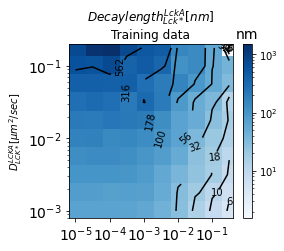

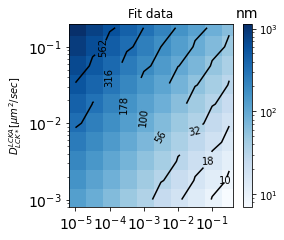

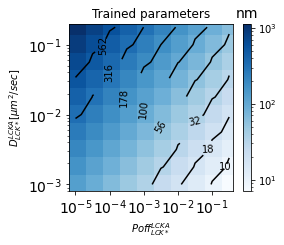

In [31]:
DataToPlot[2] = [[logPoff,logDiff],[logDLALCK_trained]]
plotWhat=[True,True,True,False]

plotData(DataToPlot, plotWhat)

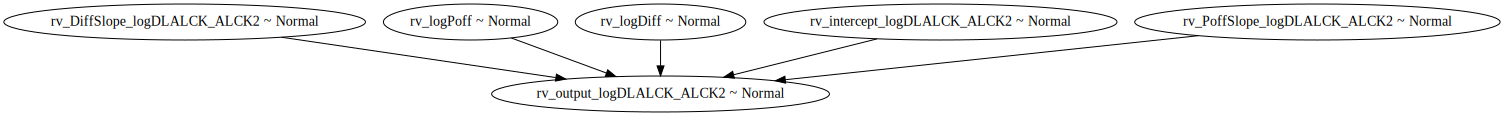

In [32]:
#@title Build trained model (with updated parameter estimates through their posteriors)
def get_pm_model2_trained(df_model2_trainedTable, 
                          observed_logPoff = None, 
                          observed_logDiff = None):
    
    ''' return model2 trained based on trace2. 
    If observed_logPoff and/or observed_logDiff are specified, 
    return the model conditioned on those values '''
    
    pm_model2_trained = pm.Model()
    with pm_model2_trained:
        dfRV = df_model2_trainedTable
        DP = 'Distribution parameters'
        
        # model2.D:
        rv_logPoff = pm.Normal('rv_logPoff', mu = -4., sd = 1., observed= observed_logPoff)
        rv_logDiff = pm.Normal('rv_logDiff', mu = 2., sd = 1., observed= observed_logDiff)
        
        # decayLengthALCK ####################################################
        """TODO: read parameters values from RV table"""
        # rv_intercept_logDLALCK_ALCK2
        ID = 'rv_intercept_logDLALCK_ALCK2'
        rv_intercept_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_PoffSlope_logDLALCK_ALCK2
        ID = 'rv_PoffSlope_logDLALCK_ALCK2'
        rv_PoffSlope_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_DiffSlope_logDLALCK_ALCK2
        ID = 'rv_DiffSlope_logDLALCK_ALCK2'
        rv_DiffSlope_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_output_logDLALCK_ALCK2, equation:
        ID = 'rv_output_logDLALCK_ALCK2'
        rv_output_logDLALCK_ALCK2 = pm.Normal(ID, 
            mu = rv_intercept_logDLALCK_ALCK2 +\
            rv_PoffSlope_logDLALCK_ALCK2*rv_logPoff +\
            rv_DiffSlope_logDLALCK_ALCK2*rv_logDiff,
            sd = eval(dfRV.loc[ID,DP]['sd'])) #

        
    return pm_model2_trained

pm_model2_trained= get_pm_model2_trained(df_model2_trainedTable)
gv2 = pm.model_to_graphviz(pm_model2_trained)
display(gv2)

In [34]:
if True:
    nx = 20 # 20 
    ny = 20 # 20 
    Xs = np.linspace(-5., -5./nx, nx)
    Ys = np.linspace(-3., -3./ny, ny)

    Zs_mean = np.zeros((nx, ny))
    Zs_std = np.zeros((nx, ny))

    for i,y in enumerate(Ys):
        for j,x in enumerate(Xs):
            cur_model= get_pm_model2_trained(df_model2_trainedTable, observed_logPoff = x, observed_logDiff = y)
            with cur_model:
                cur_trace = pm.sample(2000, chains=4, progressbar = False);
            print(f"i,y={i,y}, j,x={j,x}")
            Zs_mean[i,j] = cur_trace.rv_output_logDLALCK_ALCK2.mean() 
            Zs_std[i,j] = cur_trace.rv_output_logDLALCK_ALCK2.std();
            
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(0, -3.0), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(1, -2.85), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(2, -2.7), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(3, -2.55), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]
The acceptance probability does not match the target. It is 0.8883096524165864, but should be close to 0.8. Try to increase the number of tuning steps.


i,y=(4, -2.4), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(4, -2.4), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(5, -2.25), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(6, -2.1), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(7, -1.95), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(8, -1.8), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(9, -1.6500000000000001), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(10, -1.5), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(11, -1.35), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(12, -1.2000000000000002), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(13, -1.05), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(14, -0.8999999999999999), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(15, -0.75), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(16, -0.6000000000000001), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(17, -0.4500000000000002), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]
The acceptance probability does not match the target. It is 0.8827157262943354, but should be close to 0.8. Try to increase the number of tuning steps.


i,y=(18, -0.30000000000000027), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(18, -0.30000000000000027), j,x=(19, -0.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(0, -5.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(1, -4.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(2, -4.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(3, -4.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(4, -4.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(5, -3.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(6, -3.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(7, -3.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(8, -3.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(9, -2.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(10, -2.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(11, -2.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(12, -2.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(13, -1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(14, -1.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(15, -1.25)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(16, -1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(17, -0.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(18, -0.5)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_output_logDLALCK_ALCK2, rv_DiffSlope_logDLALCK_ALCK2, rv_PoffSlope_logDLALCK_ALCK2, rv_intercept_logDLALCK_ALCK2]


i,y=(19, -0.15), j,x=(19, -0.25)


In [35]:
if False:
    np.save("trained_logDLALCK_ALCK_mean_20x20", Zs_mean)
    np.save("trained_logDLALCK_ALCK_std_20x20", Zs_std)


In [36]:
nx = 20 # 20 
ny = 20 # 20 
Xs = np.linspace(-5., -5./nx, nx)
Ys = np.linspace(-3., -3./ny, ny)

logDLALCK_mean = np.load('trained_logDLALCK_ALCK_mean_20x20.npy')

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


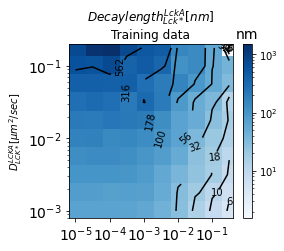

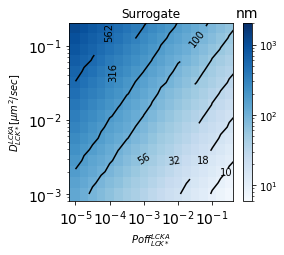

In [37]:
DataToPlot[3] = [[Xs,Ys],[logDLALCK_mean]]
plotWhat=[True,False,False,True]
# plotWhat=[True,True,True,True]

plotData(DataToPlot, plotWhat)